In [1]:
%tensorflow_version 1.14

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [5]:
import os
import json
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Install OpenPose

import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

Selecting previously unselected package libgflags2.2.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

In [0]:
# delete directory
filename = '/content/drive/My Drive/Colab Notebooks/ANN/test_openpose/'

if os.path.exists(filename):
    os.rmdir(filename)

In [25]:
# get body landmarks using open pose
!cd openpose && ./build/examples/openpose/openpose.bin --video /content/drive/My\ Drive/Colab\ Notebooks/ANN/11/test5.mp4 --write_json /content/drive/My\ Drive/Colab\ Notebooks/ANN/test_openpose1/ --display 0 --render_pose 0

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 27.068344 seconds.


In [0]:
path = '/content/drive/My Drive/Colab Notebooks/ANN/test_openpose1/'
model = load_model('/content/drive/My Drive/Colab Notebooks/ANN/model3-2.h5')

def test_prepare_data(file_name, path):
  d = list()
  for file in os.listdir(path):
    if file.startswith(file_name + '_'):
      with open(os.path.join(path, file)) as f_json:
        df = json.load(f_json)
        if (df['people'] != []):
          keypoints = df['people'][0]['pose_keypoints_2d']
          d.append(keypoints)
  return d

def testing(file_name):
  test = np.array(test_prepare_data(file_name, path))
  X_test = np.array(test)
  print("X_test shape = %s"%(str(X_test.shape)))
  y_hat = model.predict(X_test)
  print("y_hat shape = %s"%(str(y_hat.shape)))

  # show the figure
  frames = range(0, X_test.shape[0])
  plt.plot(frames, y_hat, 'bo')
  plt.ylabel('Label')
  plt.xlabel('time(frame number)')
  plt.ylim([-0.2 , 1.2])
  plt.legend()

  # create json file
  y_j = 0
  p_list = []
  for i in range(len(y_hat)):
    if y_hat[i] > 0.7 and y_hat[i+1] > 0.7:
      y_j = max(y_hat[i : i + 1]) 
      p_list.append([i, float(y_j)])

  if (y_j > 0): 
    j_dict = {"pick up": p_list}
  else:
    j_dict = {"pick up": [0, float(y_hat[0])] }

  print(j_dict)
  return j_dict


X_test shape = (305, 75)


No handles with labels found to put in legend.


y_hat shape = (305, 1)
{'pick up': [[160, 0.7322524189949036], [161, 0.7295261025428772], [162, 0.9695354700088501], [163, 0.9364688396453857], [164, 0.7386605739593506], [165, 0.9336416721343994], [193, 0.7977834343910217], [194, 0.9462175369262695], [195, 0.9800339937210083], [196, 0.7647781372070312], [197, 0.7477086782455444], [247, 0.766421914100647], [248, 0.9858099818229675], [249, 0.7144447565078735], [250, 0.9806230068206787], [251, 0.9976602792739868], [252, 0.9945660829544067], [253, 0.9633693695068359], [254, 0.9144734144210815], [255, 0.9229691028594971], [256, 0.953954815864563], [276, 0.9524412751197815], [277, 0.8867427706718445], [278, 0.9073430299758911], [279, 0.9031463861465454], [280, 0.9884887933731079], [281, 0.9916867017745972], [282, 0.844524621963501], [283, 0.9624571800231934], [284, 0.9788387417793274]]}


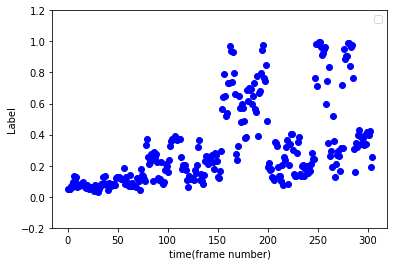

In [47]:
# test1

file_name = 'test2'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

X_test shape = (52, 75)


No handles with labels found to put in legend.


y_hat shape = (52, 1)
{'pick up': [0, 0.28414446115493774]}


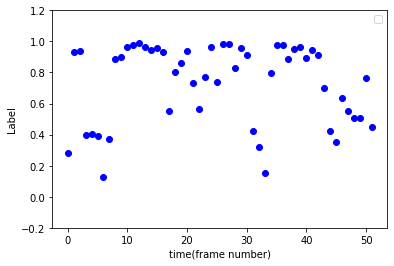

In [8]:
# test1

file_name = 'pick37'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (52, 75)
y_hat shape = (52, 1)
{'pick up': [0, 0.28414446115493774]}


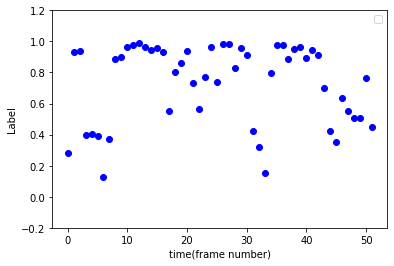

In [9]:
# test1

file_name = 'pick37'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (57, 75)
y_hat shape = (57, 1)
{'pick up': [0, 0.2941647171974182]}


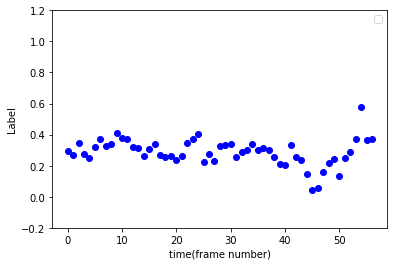

In [10]:
# test2

file_name = 'wave36'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (49, 75)
y_hat shape = (49, 1)
{'pick up': [0, 0.9775873422622681]}


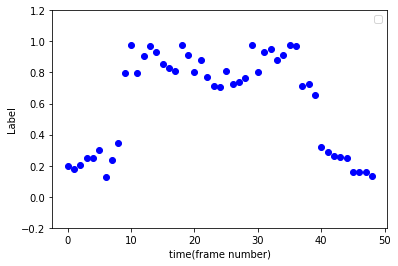

In [11]:
# test3

file_name = 'pick38'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (57, 75)
y_hat shape = (57, 1)
{'pick up': [0, 0.32388508319854736]}


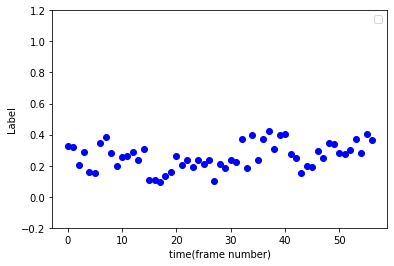

In [12]:
# test4

file_name = 'wave37'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (49, 75)
y_hat shape = (49, 1)
{'pick up': [0, 0.9958646297454834]}


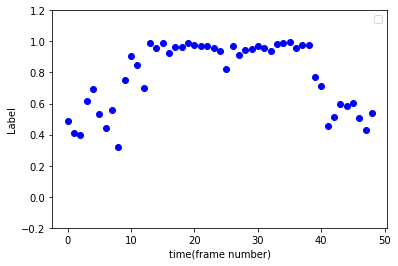

In [13]:
# test5

file_name = 'pick39'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/ANN/test_openpose/'
model = load_model('/content/drive/My Drive/Colab Notebooks/ANN/model3-256_d0.5-val.h5')

def test_prepare_data(file_name, path):
  d = list()
  for file in os.listdir(path):
    if file.startswith(file_name + '_'):
      with open(os.path.join(path, file)) as f_json:
        df = json.load(f_json)
        if (df['people'] != []):
          keypoints = df['people'][0]['pose_keypoints_2d']
          d.append(keypoints)
  return d

def testing(file_name):
  test = np.array(test_prepare_data(file_name, path))
  X_test = np.array(test)
  print("X_test shape = %s"%(str(X_test.shape)))
  y_hat = model.predict(X_test)
  print("y_hat shape = %s"%(str(y_hat.shape)))

  # show the figure
  frames = range(0, X_test.shape[0])
  plt.plot(frames, y_hat, 'bo')
  plt.ylabel('Label')
  plt.xlabel('time(frame number)')
  plt.ylim([-0.2 , 1.2])
  plt.legend()

  # create json file
  y_j = 0
  for i in range(len(y_hat)):
    if y_hat[i] > 0.7 and min(y_hat[i+1 : i + 15] > 0.7):
      y_j = max(y_hat[i : i + 15]) 

  if (y_j > 0): 
    j_dict = {"pick up": [0, float(y_j)] }
  else:
    j_dict = {"pick up": [0, float(y_hat[0])] }

  print(j_dict)
  return j_dict


X_test shape = (52, 75)
y_hat shape = (52, 1)


No handles with labels found to put in legend.


{'pick up': [0, 0.9745696187019348]}


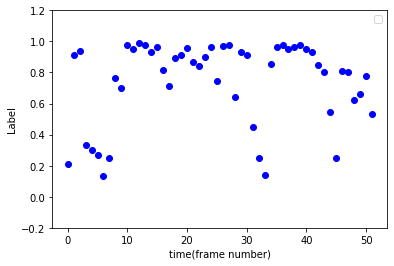

In [15]:
# test1

file_name = 'pick37'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (57, 75)
y_hat shape = (57, 1)
{'pick up': [0, 0.13907667994499207]}


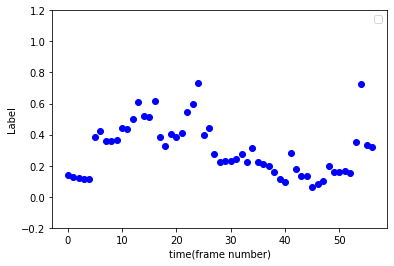

In [16]:
# test2

file_name = 'wave36'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (49, 75)
y_hat shape = (49, 1)
{'pick up': [0, 0.9634203910827637]}


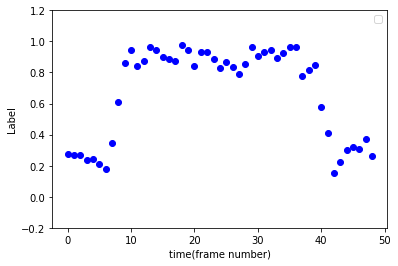

In [17]:
# test3

file_name = 'pick38'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (57, 75)
y_hat shape = (57, 1)
{'pick up': [0, 0.4509521722793579]}


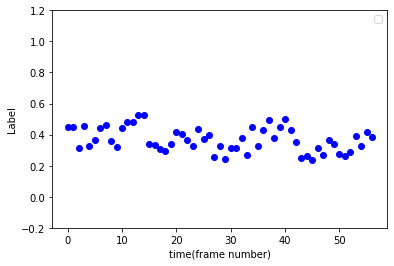

In [18]:
# test4

file_name = 'wave37'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

No handles with labels found to put in legend.


X_test shape = (49, 75)
y_hat shape = (49, 1)
{'pick up': [0, 0.9908972978591919]}


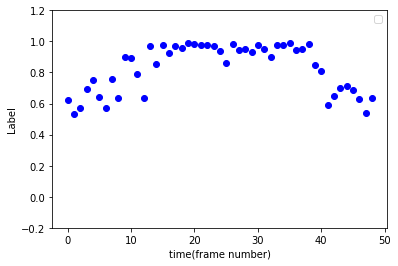

In [19]:
# test5

file_name = 'pick39'
j_dict = testing(file_name)

with open(os.path.join(path, file_name + '.json'), 'w') as fp:
    json.dump(j_dict, fp,  indent=4)

In [0]:
# test 6

